<a href="https://colab.research.google.com/github/poltorashka-s-BMa/course-os-linux/blob/main/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0__loF_ipynb_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

команды на серваке, чтобы все было в одном месте, фильтрую и получаю таблицу

In [ ]:
# bcftools view -i 'vep[*] ~ "stop_gained" || vep[*] ~ "frameshift_variant" || vep[*] ~ "сдвиг рамки считывания вправо" || vep[*] ~ "сдвиг рамки считывания влево"' gmomad.exomes.r2.11.vcf.bgz -o Lof_11.vsf.gz -Oz

In [ ]:
# bcftools stats Lof_11.vsf.gz > Lof_11_stat.txt

In [ ]:
# bcftools query -f'%CHROM\t%POS\t%REF\t%ALT\t%INFO/vep\n' lof_variants_chr11.vcf.gz >variants_for_pandas.tsv

In [ ]:
!pip install biopython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 52.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import sys
import numpy as np
import re
import math
from Bio.Seq import Seq

парсинг vep

In [ ]:

basic_headers = ['CHROM', 'POS', 'REF', 'ALT']
vep_headers = [
        "Allele", "Consequence", "IMPACT", "SYMBOL", "Gene", "Feature_type",
        "Feature", "BIOTYPE", "EXON", "INTRON", "HGVSc", "HGVSp",
        "cDNA_position", "CDS_position", "Protein_position", "Amino_acids",
        "Codons", "Existing_variation", "ALLELE_NUM", "DISTANCE", "STRAND",
        "FLAGS", "VARIANT_CLASS", "MINIMISED", "SYMBOL_SOURCE", "HGNC_ID",
        "CANONICAL", "TSL", "APPRIS", "CCDS", "ENSP", "SWISSPROT", "TREMBL",
        "UNIPARC", "GENE_PHENO", "SIFT", "PolyPhen", "DOMAINS", "HGVS_OFFSET",
        "GMAF", "AFR_MAF", "AMR_MAF", "EAS_MAF", "EUR_MAF", "SAS_MAF",
        "AA_MAF", "EA_MAF", "ExAC_MAF", "ExAC_Adj_MAF", "ExAC_AFR_MAF",
        "ExAC_AMR_MAF", "ExAC_EAS_MAF", "ExAC_FIN_MAF", "ExAC_NFE_MAF",
        "ExAC_OTH_MAF", "ExAC_SAS_MAF", "CLIN_SIG", "SOMATIC", "PHENO",
        "PUBMED", "MOTIF_NAME", "MOTIF_POS", "HIGH_INF_POS",
        "MOTIF_SCORE_CHANGE", "LoF", "LoF_filter", "LoF_flags", "LoF_info"]
stats_headers = ['TEST_CODE', 'OBS_CT', 'P_VALUE']


In [ ]:
file_path = 'loF_chr11_all_variant.tsv'
df = pd.read_csv(file_path, sep='\t', header=None, names=basic_headers + ['VEP_ANNOTATION'] + stats_headers)

In [ ]:
df

,CHROM,POS,REF,ALT,VEP_ANNOTATION,TEST_CODE,OBS_CT,P_VALUE
0,11,168941,A,G,G|splice_donor_variant|HIGH|BET1L|ENSG00000177...,2,17720,0.000112867
1,11,168942,C,A,A|splice_donor_variant|HIGH|BET1L|ENSG00000177...,1,17724,5.64207e-05
2,11,180245,G,A,A|stop_gained|HIGH|BET1L|ENSG00000177951|Trans...,0,52926,0
3,11,180317,C,CG,G|frameshift_variant|HIGH|BET1L|ENSG0000017795...,4,35506,0.000112657
4,11,180318,C,CT,T|frameshift_variant|HIGH|BET1L|ENSG0000017795...,4,31598,0.00012659
...,...,...,...,...,...,...,...,...
42077,11,134856405,G,A,A|stop_gained|HIGH|AP003062.1|ENSG00000268936|...,0,127372,0
42078,11,134856434,GA,G,-|frameshift_variant|HIGH|AP003062.1|ENSG00000...,229,127516,0.00179585
42079,11,134856440,GCAGTGGAGACCCAGCTTGCAGTCCATCAGAGGCCA,G,-|frameshift_variant|HIGH|AP003062.1|ENSG00000...,0,127858,0
42080,11,134856508,G,A,A|stop_gained|HIGH|AP003062.1|ENSG00000268936|...,1,128074,7.80799e-06


In [ ]:
df['VEP_ANNOTATION'] = df['VEP_ANNOTATION'].str.split(',')
df = df.explode('VEP_ANNOTATION').reset_index(drop=True)
vep_split = df['VEP_ANNOTATION'].str.split('|', expand =True)
num_vep_cols = vep_split.shape[1]
vep_split.columns = vep_headers[:num_vep_cols]
df = pd.concat([df.drop(columns=['VEP_ANNOTATION']), vep_split], axis=1)

In [ ]:
print (df.shape)
print(list(df.columns))


(387840, 75)
['CHROM', 'POS', 'REF', 'ALT', 'TEST_CODE', 'OBS_CT', 'P_VALUE', 'Allele', 'Consequence', 'IMPACT', 'SYMBOL', 'Gene', 'Feature_type', 'Feature', 'BIOTYPE', 'EXON', 'INTRON', 'HGVSc', 'HGVSp', 'cDNA_position', 'CDS_position', 'Protein_position', 'Amino_acids', 'Codons', 'Existing_variation', 'ALLELE_NUM', 'DISTANCE', 'STRAND', 'FLAGS', 'VARIANT_CLASS', 'MINIMISED', 'SYMBOL_SOURCE', 'HGNC_ID', 'CANONICAL', 'TSL', 'APPRIS', 'CCDS', 'ENSP', 'SWISSPROT', 'TREMBL', 'UNIPARC', 'GENE_PHENO', 'SIFT', 'PolyPhen', 'DOMAINS', 'HGVS_OFFSET', 'GMAF', 'AFR_MAF', 'AMR_MAF', 'EAS_MAF', 'EUR_MAF', 'SAS_MAF', 'AA_MAF', 'EA_MAF', 'ExAC_MAF', 'ExAC_Adj_MAF', 'ExAC_AFR_MAF', 'ExAC_AMR_MAF', 'ExAC_EAS_MAF', 'ExAC_FIN_MAF', 'ExAC_NFE_MAF', 'ExAC_OTH_MAF', 'ExAC_SAS_MAF', 'CLIN_SIG', 'SOMATIC', 'PHENO', 'PUBMED', 'MOTIF_NAME', 'MOTIF_POS', 'HIGH_INF_POS', 'MOTIF_SCORE_CHANGE', 'LoF', 'LoF_filter', 'LoF_flags', 'LoF_info']


In [ ]:
df

,CHROM,POS,REF,ALT,TEST_CODE,OBS_CT,P_VALUE,Allele,Consequence,IMPACT,...,PHENO,PUBMED,MOTIF_NAME,MOTIF_POS,HIGH_INF_POS,MOTIF_SCORE_CHANGE,LoF,LoF_filter,LoF_flags,LoF_info
0,11,168941,A,G,2,17720,0.000112867,G,splice_donor_variant,HIGH,...,,,,,,,LC,3UTR_SPLICE,,INTRON_SIZE:1058
1,11,168941,A,G,2,17720,0.000112867,G,intron_variant&non_coding_transcript_variant,MODIFIER,...,,,,,,,,,,
2,11,168941,A,G,2,17720,0.000112867,G,regulatory_region_variant,MODIFIER,...,,,,,,,,,,
3,11,168942,C,A,1,17724,5.64207e-05,A,splice_donor_variant,HIGH,...,,,,,,,LC,3UTR_SPLICE,,INTRON_SIZE:1058
4,11,168942,C,A,1,17724,5.64207e-05,A,intron_variant&non_coding_transcript_variant,MODIFIER,...,,,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
387835,11,134856405,G,A,0,127372,0,A,stop_gained,HIGH,...,,,,,,,LC,END_TRUNC,SINGLE_EXON,GERP_DIST:6.78&BP_DIST:238&PERCENTILE:0.809752...
387836,11,134856434,GA,G,229,127516,0.00179585,-,frameshift_variant,HIGH,...,,,,,,,LC,END_TRUNC,SINGLE_EXON,GERP_DIST:6.78&BP_DIST:208&PERCENTILE:0.833733...
387837,11,134856440,GCAGTGGAGACCCAGCTTGCAGTCCATCAGAGGCCA,G,0,127858,0,-,frameshift_variant,HIGH,...,,,,,,,LC,END_TRUNC,SINGLE_EXON,GERP_DIST:6.78&BP_DIST:202&PERCENTILE:0.865707...
387838,11,134856508,G,A,1,128074,7.80799e-06,A,stop_gained,HIGH,...,,,,,,,LC,END_TRUNC,SINGLE_EXON,GERP_DIST:6.78&BP_DIST:135&PERCENTILE:0.892086...


напарсила таблицу, теперь фильтрую (добавbать нормализацию и частоты lof)

In [ ]:
columns_to_keep = [
    'CHROM', 'POS', 'REF', 'ALT', 'SYMBOL', 'Gene', 'Feature', 'BIOTYPE', 'EXON', 'INTRON',
    'Consequence', 'IMPACT', 'CDS_position', 'Protein_position','LoF_filter', 'LoF_flags', 'FLAGS',"ALLELE_NUM", 'HGVSc', 'HGVSp', 'CANONICAL', 'LoF_filter'
]
lof_keywords = ['stop_gained','frameshift_variant','splice_donor_variant', 'splice_acceptor_variant']

# Регулярка, которая ищет хотя бы одно ключевое слово
pattern = re.compile("|".join(lof_keywords))

# Фильтрация по Consequence
df = df[df['Consequence'].astype(str).str.contains(pattern)]
# Фильтрация по lof_filter
df = df[df['LoF_filter'].isin(['END_TRUNC', ''])]
# Проверка столбцов в  df

existing_columns_to_keep = [col for col in columns_to_keep if col in df.columns]

# новый DataFrame
df_final_filtered = df[existing_columns_to_keep]


#фильтрую транскрипты по koл-во lof >=5
lof_counts_per_transcript = df_final_filtered['Feature'].value_counts()


# список  транскриптов, которые >=5
reliable_transcripts = lof_counts_per_transcript[lof_counts_per_transcript >=5].index

print(f"Найдено {len(reliable_transcripts)} транскриптов с 5 и более LoF мутациями.")


# Фильтрую lof_only_df
df_final_filtered =df_final_filtered[df_final_filtered['Feature'].isin(reliable_transcripts)]




#output_file = 'lof_filtered.tsv'
#df_final_filtered.to_csv(output_file, sep='\t', index=False)



Найдено 5578 транскриптов с 5 и более LoF мутациями.


In [ ]:
uniq= (df_final_filtered['Consequence'].value_counts())
print((uniq))

Consequence
frameshift_variant                                                                    46537
stop_gained                                                                           30477
splice_donor_variant                                                                  11429
splice_acceptor_variant                                                                9209
frameshift_variant&NMD_transcript_variant                                              3291
                                                                                      ...  
splice_acceptor_variant&synonymous_variant                                                1
stop_gained&protein_altering_variant&splice_region_variant                                1
splice_acceptor_variant&missense_variant                                                  1
splice_donor_variant&splice_acceptor_variant&intron_variant&NMD_transcript_variant        1
splice_donor_variant&coding_sequence_variant&5_prime_UTR_variant&int

In [ ]:
df_final_filtered

,CHROM,POS,REF,ALT,SYMBOL,Gene,Feature,BIOTYPE,EXON,INTRON,...,IMPACT,CDS_position,Protein_position,LoF_filter,LoF_flags,FLAGS,HGVSc,HGVSp,CANONICAL,LoF_filter
6,11,180245,G,A,BET1L,ENSG00000177951,ENST00000410108,protein_coding,4/6,,...,HIGH,328,110,,,,ENST00000410108.1:c.328C>T,ENSP00000386558.1:p.Gln110Ter,,
10,11,180317,C,CG,BET1L,ENSG00000177951,ENST00000410108,protein_coding,4/6,,...,HIGH,255-256,85-86,,,,ENST00000410108.1:c.255_256insC,ENSP00000386558.1:p.Ala86ArgfsTer31,,
15,11,180318,C,CT,BET1L,ENSG00000177951,ENST00000410108,protein_coding,4/6,,...,HIGH,254-255,85,,,,ENST00000410108.1:c.254_255insA,ENSP00000386558.1:p.Ala86GlyfsTer31,,
20,11,180368,G,A,BET1L,ENSG00000177951,ENST00000410108,protein_coding,4/6,,...,HIGH,205,69,,,,ENST00000410108.1:c.205C>T,ENSP00000386558.1:p.Arg69Ter,,
24,11,180406,T,G,BET1L,ENSG00000177951,ENST00000410108,protein_coding,,3/5,...,HIGH,,,,,,ENST00000410108.1:c.169-2A>C,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
387835,11,134856405,G,A,AP003062.1,ENSG00000268936,ENST00000597621,protein_coding,1/1,,...,HIGH,1013,338,END_TRUNC,SINGLE_EXON,,ENST00000597621.1:c.1013G>A,ENSP00000470409.1:p.Trp338Ter,YES,END_TRUNC
387836,11,134856434,GA,G,AP003062.1,ENSG00000268936,ENST00000597621,protein_coding,1/1,,...,HIGH,1043,348,END_TRUNC,SINGLE_EXON,,ENST00000597621.1:c.1043delA,ENSP00000470409.1:p.Glu348GlyfsTer60,YES,END_TRUNC
387837,11,134856440,GCAGTGGAGACCCAGCTTGCAGTCCATCAGAGGCCA,G,AP003062.1,ENSG00000268936,ENST00000597621,protein_coding,1/1,,...,HIGH,1049-1083,350-361,END_TRUNC,SINGLE_EXON,,ENST00000597621.1:c.1049_1083delCAGTGGAGACCCAG...,ENSP00000470409.1:p.Ala350GlyfsTer35,YES,END_TRUNC
387838,11,134856508,G,A,AP003062.1,ENSG00000268936,ENST00000597621,protein_coding,1/1,,...,HIGH,1116,372,END_TRUNC,SINGLE_EXON,,ENST00000597621.1:c.1116G>A,ENSP00000470409.1:p.Trp372Ter,YES,END_TRUNC


In [ ]:
df_exons_lenghts= pd.read_csv("gencode_v43_exons.tsv",  sep='\t')
df_cds_lenghts= pd.read_csv("gencode_v43_cds.tsv",  sep='\t')
#df_final_filtered= pd.read_csv("clinvar_filter_vep_full.tsv",  sep='\t')

использовать  48!!! версью genecode

In [ ]:
df_cds_lenghts

,transcript_id,cds_length,protein_length
0,ENST00000335137,918,306
1,ENST00000423372,780,260
2,ENST00000426406,939,313
3,ENST00000332831,939,313
4,ENST00000599533,129,43
...,...,...,...
81740,ENST00000361335,297,99
81741,ENST00000361381,1378,459
81742,ENST00000361567,1812,604
81743,ENST00000361681,525,175


In [ ]:
df_merged_lof_cds = (
    df_final_filtered.merge(df_cds_lenghts, left_on="Feature", right_on="transcript_id", how="left"))

#output_file = 'lof_filtered_with_protein.tsv'
#df_merged_lof_cds.to_csv(output_file, sep='\t', index=False)

In [ ]:
df_merged_lof_cds

,CHROM,POS,REF,ALT,SYMBOL,Gene,Feature,BIOTYPE,EXON,INTRON,...,LoF_flags,FLAGS,ALLELE_NUM,HGVSc,HGVSp,CANONICAL,LoF_filter,transcript_id,cds_length,protein_length
0,11,180245,G,A,BET1L,ENSG00000177951,ENST00000410108,protein_coding,4/6,,...,,,1,ENST00000410108.1:c.328C>T,ENSP00000386558.1:p.Gln110Ter,,,ENST00000410108,459.0,153.0
1,11,180317,C,CG,BET1L,ENSG00000177951,ENST00000410108,protein_coding,4/6,,...,,,1,ENST00000410108.1:c.255_256insC,ENSP00000386558.1:p.Ala86ArgfsTer31,,,ENST00000410108,459.0,153.0
2,11,180318,C,CT,BET1L,ENSG00000177951,ENST00000410108,protein_coding,4/6,,...,,,1,ENST00000410108.1:c.254_255insA,ENSP00000386558.1:p.Ala86GlyfsTer31,,,ENST00000410108,459.0,153.0
3,11,180368,G,A,BET1L,ENSG00000177951,ENST00000410108,protein_coding,4/6,,...,,,1,ENST00000410108.1:c.205C>T,ENSP00000386558.1:p.Arg69Ter,,,ENST00000410108,459.0,153.0
4,11,180406,T,G,BET1L,ENSG00000177951,ENST00000410108,protein_coding,,3/5,...,,,1,ENST00000410108.1:c.169-2A>C,,,,ENST00000410108,459.0,153.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118139,11,134856405,G,A,AP003062.1,ENSG00000268936,ENST00000597621,protein_coding,1/1,,...,SINGLE_EXON,,1,ENST00000597621.1:c.1013G>A,ENSP00000470409.1:p.Trp338Ter,YES,END_TRUNC,ENST00000597621,1251.0,417.0
118140,11,134856434,GA,G,AP003062.1,ENSG00000268936,ENST00000597621,protein_coding,1/1,,...,SINGLE_EXON,,1,ENST00000597621.1:c.1043delA,ENSP00000470409.1:p.Glu348GlyfsTer60,YES,END_TRUNC,ENST00000597621,1251.0,417.0
118141,11,134856440,GCAGTGGAGACCCAGCTTGCAGTCCATCAGAGGCCA,G,AP003062.1,ENSG00000268936,ENST00000597621,protein_coding,1/1,,...,SINGLE_EXON,,1,ENST00000597621.1:c.1049_1083delCAGTGGAGACCCAG...,ENSP00000470409.1:p.Ala350GlyfsTer35,YES,END_TRUNC,ENST00000597621,1251.0,417.0
118142,11,134856508,G,A,AP003062.1,ENSG00000268936,ENST00000597621,protein_coding,1/1,,...,SINGLE_EXON,,1,ENST00000597621.1:c.1116G>A,ENSP00000470409.1:p.Trp372Ter,YES,END_TRUNC,ENST00000597621,1251.0,417.0


вот здесь фильтрую транскрипты и нормальзую их

In [ ]:
df_merged_lof_cds.dropna(subset=['Feature', 'cds_length'], inplace=True)
df_merged_lof_cds['cds_length'] = pd.to_numeric(df_merged_lof_cds['cds_length'], errors='coerce')
transcript_stats = df_merged_lof_cds.groupby('Feature').agg(
    lof_count=('Feature', 'size'),
    cds_length=('cds_length', 'first')
)


transcript_stats['lof_density_per_kb'] = (transcript_stats['lof_count'] / transcript_stats['cds_length']) * 1000
transcript_stats

,lof_count,cds_length,lof_density_per_kb
Feature,,,
ENST00000005226,177,2700.0,65.555556
ENST00000016913,1,804.0,1.243781
ENST00000064780,1,1293.0,0.773395
ENST00000155840,287,2031.0,141.309700
ENST00000164139,203,2529.0,80.268881
...,...,...,...
ENST00000597505,1,5352.0,0.186846
ENST00000601453,143,405.0,353.086420
ENST00000602866,1,1272.0,0.786164


In [ ]:
transcript_stats = transcript_stats[transcript_stats["lof_density_per_kb"]>=7]
transcript_stats

,lof_count,cds_length,lof_density_per_kb
Feature,,,
ENST00000005226,177,2700.0,65.555556
ENST00000155840,287,2031.0,141.309700
ENST00000164139,203,2529.0,80.268881
ENST00000227157,7,726.0,9.641873
ENST00000227163,6,816.0,7.352941
...,...,...,...
ENST00000565318,18,404.0,44.554455
ENST00000569129,17,353.0,48.158640
ENST00000596081,1,51.0,19.607843


In [ ]:
df_merged_lof_cds =  df_merged_lof_cds.merge(transcript_stats, on='Feature', how='left')
df_merged_lof_cds

NameError: name 'transcript_stats' is not defined

Делю таблицу на сплайсинговую и на остальные lof

In [ ]:
# Маска для всех splice, кроме тех, что содержат stop_gained или frameshift вместе с splice_region
splice_mask = (
    df_merged_lof_cds['Consequence'].str.contains('splice', na=False) &
    ~df_merged_lof_cds['Consequence'].str.contains("stop_gained|frameshift",  na=False ))

df_splice = df_merged_lof_cds[splice_mask].copy()
df_other_lof = df_merged_lof_cds[~splice_mask].copy()

stop_gained&protein_altering_variant&splice_region_variant  все такие отфильтровываем

In [ ]:
df_splice= df_splice[~df_splice['Consequence'].str.contains('NMD_transcript_variant|non_coding_transcript|&3_prime_UTR_variant')]

In [ ]:
print(df_splice['Consequence'].value_counts())

Consequence
splice_donor_variant                                                                   11429
splice_acceptor_variant                                                                 9209
splice_acceptor_variant&coding_sequence_variant&intron_variant                           545
splice_donor_variant&coding_sequence_variant&intron_variant                              483
splice_donor_variant&coding_sequence_variant                                             301
splice_donor_variant&intron_variant                                                      288
splice_acceptor_variant&coding_sequence_variant                                          266
splice_acceptor_variant&intron_variant                                                   244
splice_donor_variant&splice_acceptor_variant&intron_variant                               20
splice_acceptor_variant&coding_sequence_variant&5_prime_UTR_variant&intron_variant        12
splice_acceptor_variant&splice_donor_variant&coding_sequen

In [ ]:
df_other_lof= df_other_lof[~df_other_lof['Consequence'].str.contains("non_coding_transcript|NMD_transcript_variant|stop_gained&protein_altering_variant&splice_region_variant|frameshift_variant&splice_region_variant|stop_gained&splice_region_variant|3_prime_UTR")]

In [ ]:
print(df_other_lof['Consequence'].value_counts())


Consequence
frameshift_variant                                     46537
stop_gained                                            30477
stop_gained&frameshift_variant                           941
frameshift_variant&stop_lost                             165
stop_gained&inframe_insertion                            148
frameshift_variant&start_lost                             84
stop_gained&protein_altering_variant                      78
frameshift_variant&stop_retained_variant                  52
stop_gained&inframe_deletion                              21
stop_gained&inframe_insertion&splice_region_variant       13
splice_donor_variant&frameshift_variant                    3
stop_gained&start_lost                                     2
frameshift_variant&stop_lost&splice_region_variant         2
splice_acceptor_variant&frameshift_variant                 2
stop_gained&inframe_deletion&splice_region_variant         1
Name: count, dtype: int64


In [ ]:
df_splice.to_csv('splise.tsv', sep='\t', index=False)

In [ ]:
df_splice

,CHROM,POS,REF,ALT,SYMBOL,Gene,Feature,BIOTYPE,EXON,INTRON,...,LoF_flags,FLAGS,ALLELE_NUM,HGVSc,HGVSp,CANONICAL,LoF_filter,transcript_id,cds_length,protein_length
4,11,180406,T,G,BET1L,ENSG00000177951,ENST00000410108,protein_coding,,3/5,...,,,1,ENST00000410108.1:c.169-2A>C,,,,ENST00000410108,459.0,153.0
5,11,193155,G,A,SCGB1C1,ENSG00000188076,ENST00000342878,protein_coding,,1/2,...,,,1,ENST00000342878.2:c.55+1G>A,,YES,,ENST00000342878,288.0,96.0
6,11,193155,G,C,SCGB1C1,ENSG00000188076,ENST00000342878,protein_coding,,1/2,...,,,1,ENST00000342878.2:c.55+1G>C,,YES,,ENST00000342878,288.0,96.0
14,11,193912,G,A,SCGB1C1,ENSG00000188076,ENST00000342878,protein_coding,,2/2,...,,,1,ENST00000342878.2:c.255+1G>A,,YES,,ENST00000342878,288.0,96.0
15,11,193912,G,GT,SCGB1C1,ENSG00000188076,ENST00000342878,protein_coding,,2/2,...,,,1,ENST00000342878.2:c.255+2dupT,,YES,,ENST00000342878,288.0,96.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117952,11,134241725,G,C,GLB1L2,ENSG00000149328,ENST00000339772,protein_coding,,15/19,...,,,1,ENST00000339772.7:c.1507+1G>C,,,,ENST00000339772,1911.0,637.0
117953,11,134241725,G,C,GLB1L2,ENSG00000149328,ENST00000389881,protein_coding,,15/20,...,,,1,ENST00000389881.3:c.1507+1G>C,,,,ENST00000389881,1911.0,637.0
117954,11,134241725,G,C,GLB1L2,ENSG00000149328,ENST00000525089,protein_coding,,14/17,...,,cds_start_NF,1,ENST00000525089.2:c.1322+1G>C,,,,ENST00000525089,1726.0,575.0
117956,11,134241725,G,C,GLB1L2,ENSG00000149328,ENST00000535456,protein_coding,,15/18,...,,,1,ENST00000535456.2:c.1507+1G>C,,YES,,ENST00000535456,1911.0,637.0


Загружаем cds_seq (пришлось сделать в R)

In [ ]:
cds_seq = pd.read_csv("transcript_cds_sequences.tsv", sep='\t')
cds_seq

,transcript_id,cds_sequence
0,ENST00000236671,ATGCAGCCCTCCAGCCTTCTGCCGCTCGCCCTCTGCCTGCTGGCTG...
1,ENST00000252898,ATGGGAGATGAGGAGAAGCGGAACAGGGCCATCACGGCCCGCAGGC...
2,ENST00000250699,ATGGGGCTCCGGAGCCACCACCTCAGCCTGGGCCTTCTGCTTCTGT...
3,ENST00000155858,ATGCAGGATGTCCAAGGCCCCCGTCCCGGAAGCCCCGGGGATGCTG...
4,ENST00000254436,ATGGCTTCAGCAGCACGCTTGACAATGATGTGGGAGGAGGTCACAT...
...,...,...
4387,ENST00000534070,ATGGCAGTGCCCTTTGTGGAAGACTGGGACTTGGTGCAAACCCTGG...
4388,ENST00000542175,ATGTCCCGCCCCCACCCTACCAGGACAGCCCACAGGCACCCTCTTT...
4389,ENST00000534733,ATGAGTGTCCTGAGTGGCCCTGGATGGACTACTGGCTGTCCCTGGC...
4390,ENST00000534230,ATGGATCTTGTACTCCGTGTTGCAGATTACTATTTTTTTACACCAT...


In [ ]:
splice_seq = cds_seq.merge(df_splice, on="transcript_id",how = "left")
splice_seq

,transcript_id,cds_sequence,CHROM,POS,REF,ALT,SYMBOL,Gene,Feature,BIOTYPE,...,LoF_filter,LoF_flags,FLAGS,ALLELE_NUM,HGVSc,HGVSp,CANONICAL,LoF_filter,cds_length,protein_length
0,ENST00000236671,ATGCAGCCCTCCAGCCTTCTGCCGCTCGCCCTCTGCCTGCTGGCTG...,11.0,1775032.0,C,A,CTSD,ENSG00000117984,ENST00000236671,protein_coding,...,,,,1,ENST00000236671.2:c.1071+1G>T,,YES,,1239.0,413.0
1,ENST00000236671,ATGCAGCCCTCCAGCCTTCTGCCGCTCGCCCTCTGCCTGCTGGCTG...,11.0,1775131.0,ACTAAGAGGGGTCACAGCAGTGTCAGGGTGGTAGTGGTGGCCTTGG...,A,CTSD,ENSG00000117984,ENST00000236671,protein_coding,...,,,,1,ENST00000236671.2:c.973-1_972+1delGTGAGCGCCGGG...,,YES,,1239.0,413.0
2,ENST00000236671,ATGCAGCCCTCCAGCCTTCTGCCGCTCGCCCTCTGCCTGCTGGCTG...,11.0,1776260.0,T,C,CTSD,ENSG00000117984,ENST00000236671,protein_coding,...,,,,1,ENST00000236671.2:c.705-2A>G,,YES,,1239.0,413.0
3,ENST00000236671,ATGCAGCCCTCCAGCCTTCTGCCGCTCGCCCTCTGCCTGCTGGCTG...,11.0,1778553.0,C,T,CTSD,ENSG00000117984,ENST00000236671,protein_coding,...,,,,1,ENST00000236671.2:c.704+1G>A,,YES,,1239.0,413.0
4,ENST00000236671,ATGCAGCCCTCCAGCCTTCTGCCGCTCGCCCTCTGCCTGCTGGCTG...,11.0,1778788.0,T,C,CTSD,ENSG00000117984,ENST00000236671,protein_coding,...,,,,1,ENST00000236671.2:c.472-2A>G,,YES,,1239.0,413.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23394,ENST00000534230,ATGGATCTTGTACTCCGTGTTGCAGATTACTATTTTTTTACACCAT...,11.0,121177196.0,G,T,SC5D,ENSG00000109929,ENST00000534230,protein_coding,...,,,,1,ENST00000534230.1:c.444+1G>T,,,,687.0,229.0
23395,ENST00000534230,ATGGATCTTGTACTCCGTGTTGCAGATTACTATTTTTTTACACCAT...,11.0,121177765.0,G,A,SC5D,ENSG00000109929,ENST00000534230,protein_coding,...,,,,1,ENST00000534230.1:c.445-1G>A,,,,687.0,229.0
23396,ENST00000534230,ATGGATCTTGTACTCCGTGTTGCAGATTACTATTTTTTTACACCAT...,11.0,121178164.0,A,G,SC5D,ENSG00000109929,ENST00000534230,protein_coding,...,,,,1,ENST00000534230.1:c.632-2A>G,,,,687.0,229.0
23397,ENST00000577924,NNGGTTTGGGATGCTCTGACAGACAATTACATCCCTTCACTCTCAG...,11.0,125330393.0,C,A,FEZ1,ENSG00000149557,ENST00000577924,protein_coding,...,,,cds_start_NF&cds_end_NF,1,ENST00000577924.1:c.464+1G>T,,,,619.0,206.0


ну начинаем считать p/l

работаю проблеммами в сплайсинге

In [ ]:
def get_target_exon_number(row):
    consequence = str(row["Consequence"])
    intron_str = str(row["INTRON"])
    if pd.isna(row["INTRON"]) or "/" not in intron_str: return None
    try:
        intron_num = int(intron_str.split("/")[0])
        if 'donor' in consequence.lower(): return intron_num
        elif 'acceptor' in consequence.lower(): return intron_num + 1
        return None
    except (ValueError, IndexError): return None

splice_seq["target_exon_number"] = splice_seq.apply(get_target_exon_number, axis=1)

#  меняю тип значения
splice_seq.dropna(subset=['target_exon_number'], inplace=True)
splice_seq['target_exon_number'] = splice_seq['target_exon_number'].astype(int)


splice_seq['transcript_id_clean'] = splice_seq['Feature'].str.split('.').str[0]
df_exons_lenghts['transcript_id_clean'] = df_exons_lenghts['transcript_id'].str.split('.').str[0]


# убираю дубликаты в таблице экзонов
df_exons_unique = df_exons_lenghts.drop_duplicates(subset=['transcript_id_clean', 'exon_number'])


merged_df = pd.merge(
    splice_seq, df_exons_unique, left_on=["transcript_id_clean", "target_exon_number"], right_on=["transcript_id_clean", "exon_number"],
    how="inner"
)

merged_df = merged_df.drop(["transcript_id_x","transcript_id_y"], axis=1)


merged_df['skipped_exon_length'] = merged_df['exon_length']

In [ ]:
merged_df

,cds_sequence,CHROM,POS,REF,ALT,SYMBOL,Gene,Feature,BIOTYPE,EXON,...,cds_length,protein_length,target_exon_number,transcript_id_clean,gene_id,gene_name,exon_number,total_exons,exon_length,skipped_exon_length
0,ATGCAGCCCTCCAGCCTTCTGCCGCTCGCCCTCTGCCTGCTGGCTG...,11.0,1775032.0,C,A,CTSD,ENSG00000117984,ENST00000236671,protein_coding,,...,1239.0,413.0,8,ENST00000236671,ENSG00000117984,CTSD,8,9,99,99
1,ATGCAGCCCTCCAGCCTTCTGCCGCTCGCCCTCTGCCTGCTGGCTG...,11.0,1775131.0,ACTAAGAGGGGTCACAGCAGTGTCAGGGTGGTAGTGGTGGCCTTGG...,A,CTSD,ENSG00000117984,ENST00000236671,protein_coding,,...,1239.0,413.0,7,ENST00000236671,ENSG00000117984,CTSD,7,9,145,145
2,ATGCAGCCCTCCAGCCTTCTGCCGCTCGCCCTCTGCCTGCTGGCTG...,11.0,1776260.0,T,C,CTSD,ENSG00000117984,ENST00000236671,protein_coding,,...,1239.0,413.0,6,ENST00000236671,ENSG00000117984,CTSD,6,9,123,123
3,ATGCAGCCCTCCAGCCTTCTGCCGCTCGCCCTCTGCCTGCTGGCTG...,11.0,1778553.0,C,T,CTSD,ENSG00000117984,ENST00000236671,protein_coding,,...,1239.0,413.0,5,ENST00000236671,ENSG00000117984,CTSD,5,9,233,233
4,ATGCAGCCCTCCAGCCTTCTGCCGCTCGCCCTCTGCCTGCTGGCTG...,11.0,1778788.0,T,C,CTSD,ENSG00000117984,ENST00000236671,protein_coding,,...,1239.0,413.0,5,ENST00000236671,ENSG00000117984,CTSD,5,9,233,233
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22734,ATGGATCTTGTACTCCGTGTTGCAGATTACTATTTTTTTACACCAT...,11.0,121177196.0,G,T,SC5D,ENSG00000109929,ENST00000534230,protein_coding,,...,687.0,229.0,4,ENST00000534230,ENSG00000109929,SC5D,4,6,101,101
22735,ATGGATCTTGTACTCCGTGTTGCAGATTACTATTTTTTTACACCAT...,11.0,121177765.0,G,A,SC5D,ENSG00000109929,ENST00000534230,protein_coding,,...,687.0,229.0,5,ENST00000534230,ENSG00000109929,SC5D,5,6,187,187
22736,ATGGATCTTGTACTCCGTGTTGCAGATTACTATTTTTTTACACCAT...,11.0,121178164.0,A,G,SC5D,ENSG00000109929,ENST00000534230,protein_coding,,...,687.0,229.0,6,ENST00000534230,ENSG00000109929,SC5D,6,6,1174,1174
22737,NNGGTTTGGGATGCTCTGACAGACAATTACATCCCTTCACTCTCAG...,11.0,125330393.0,C,A,FEZ1,ENSG00000149557,ENST00000577924,protein_coding,,...,619.0,206.0,4,ENST00000577924,ENSG00000149557,FEZ1,4,5,169,169


In [ ]:

#Разделение на простые и сложные мутации
simple_mutation = merged_df['exon_length'] % 3 == 0
df_simple = merged_df[simple_mutation].copy()
df_complex = merged_df[~simple_mutation].copy()

merged_df.dropna(subset=['exon_length', 'HGVSc', 'cds_sequence'], inplace=True)
merged_df['exon_length'] = merged_df['exon_length'].astype(int)



#Расчет p/l для простых мутаций
skipped_protein_length = df_simple['exon_length'] / 3

#Считаем p/l по изи формуле
df_simple.loc[:,'p/l'] = (df_simple['protein_length'] - skipped_protein_length) / df_simple['protein_length']


#Расчет p/l для сложных мутаций


#функция для стоп кодона
def cds_to_protein(cds_sequence: str) -> int | None:
  if not cds_sequence:
    return None
  try:
        # Создаем объект "Последовательность" из нашей сломанной ДНК
        mutant_seq_obj = Seq(cds_sequence)

        # Переводим в белок, ОСТАНАВЛИВАЯСЬ на первом же стоп-кодоне
        mutant_protein = mutant_seq_obj.translate(to_stop=True)

        broken_protein_len = len(mutant_protein)
        return broken_protein_len
  except:
    return None





def calc_pl_splice(row):
    hgvsc = str(row['HGVSc'])
    exon_len = row['exon_length']
    cds_sequence = row['cds_sequence']
    cds_length = row['cds_length']
    consequence = str(row['Consequence']).lower()

    match = re.search(r'c\.(\d+)', hgvsc)
    if not match:
        return None
    mutant_dna =None
    if "acceptor" in consequence:
      exon_pos_start = int(match.group(1))
      exon_pos_end = exon_pos_start + exon_len
      if  exon_pos_end <= len(cds_sequence):
        mutant_dna = cds_sequence[:exon_pos_start] + cds_sequence[exon_pos_end:]



    elif "donor" in consequence:
     exon_pos_end = int(match.group(1))
     exon_pos_start = exon_pos_end - exon_len
     if exon_pos_start>=0:
      mutant_dna= cds_sequence[:exon_pos_start] + cds_sequence[exon_pos_end:]
    if mutant_dna is None:
      return None






    broken_protein_len = cds_to_protein(mutant_dna)
    if broken_protein_len is None:
        return None

    # расчет p/l
    pl = (broken_protein_len*3+exon_len) / cds_length
    return (pl)
df_complex.loc[:,"p/l"] = df_complex.apply(calc_pl_splice, axis=1)


#df_complex= df_complex.drop(["skipped_exon_length"], axis =1)





/usr/local/lib/python3.12/dist-packages/Bio/Seq.py:2879: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(


In [ ]:
df_complex

,cds_sequence,CHROM,POS,REF,ALT,SYMBOL,Gene,Feature,BIOTYPE,EXON,...,protein_length,target_exon_number,transcript_id_clean,gene_id,gene_name,exon_number,total_exons,exon_length,skipped_exon_length,p/l
1,ATGCAGCCCTCCAGCCTTCTGCCGCTCGCCCTCTGCCTGCTGGCTG...,11.0,1775131.0,ACTAAGAGGGGTCACAGCAGTGTCAGGGTGGTAGTGGTGGCCTTGG...,A,CTSD,ENSG00000117984,ENST00000236671,protein_coding,,...,413.0,7,ENST00000236671,ENSG00000117984,CTSD,7,9,145,145,0.998386
3,ATGCAGCCCTCCAGCCTTCTGCCGCTCGCCCTCTGCCTGCTGGCTG...,11.0,1778553.0,C,T,CTSD,ENSG00000117984,ENST00000236671,protein_coding,,...,413.0,5,ENST00000236671,ENSG00000117984,CTSD,5,9,233,233,0.587571
4,ATGCAGCCCTCCAGCCTTCTGCCGCTCGCCCTCTGCCTGCTGGCTG...,11.0,1778788.0,T,C,CTSD,ENSG00000117984,ENST00000236671,protein_coding,,...,413.0,5,ENST00000236671,ENSG00000117984,CTSD,5,9,233,233,0.587571
5,ATGCAGCCCTCCAGCCTTCTGCCGCTCGCCCTCTGCCTGCTGGCTG...,11.0,1782538.0,C,G,CTSD,ENSG00000117984,ENST00000236671,protein_coding,,...,413.0,2,ENST00000236671,ENSG00000117984,CTSD,2,9,160,160,0.317998
6,ATGCAGCCCTCCAGCCTTCTGCCGCTCGCCCTCTGCCTGCTGGCTG...,11.0,1782538.0,C,T,CTSD,ENSG00000117984,ENST00000236671,protein_coding,,...,413.0,2,ENST00000236671,ENSG00000117984,CTSD,2,9,160,160,0.317998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22733,ATGGATCTTGTACTCCGTGTTGCAGATTACTATTTTTTTACACCAT...,11.0,121175203.0,G,T,SC5D,ENSG00000109929,ENST00000534230,protein_coding,,...,229.0,3,ENST00000534230,ENSG00000109929,SC5D,3,6,133,133,0.534207
22734,ATGGATCTTGTACTCCGTGTTGCAGATTACTATTTTTTTACACCAT...,11.0,121177196.0,G,T,SC5D,ENSG00000109929,ENST00000534230,protein_coding,,...,229.0,4,ENST00000534230,ENSG00000109929,SC5D,4,6,101,101,0.657933
22735,ATGGATCTTGTACTCCGTGTTGCAGATTACTATTTTTTTACACCAT...,11.0,121177765.0,G,A,SC5D,ENSG00000109929,ENST00000534230,protein_coding,,...,229.0,5,ENST00000534230,ENSG00000109929,SC5D,5,6,187,187,0.997089
22736,ATGGATCTTGTACTCCGTGTTGCAGATTACTATTTTTTTACACCAT...,11.0,121178164.0,A,G,SC5D,ENSG00000109929,ENST00000534230,protein_coding,,...,229.0,6,ENST00000534230,ENSG00000109929,SC5D,6,6,1174,1174,NaN


Расчет p/l нонсенс и фраймшифт

In [ ]:

def calc_pl_other_lof(hgvsp, protein_length=None, cds_length=None):

    if not hgvsp:
        return None

    aa_len = None
    if protein_length  > 0:
        aa_len = int(protein_length)
    elif cds_length and cds_length > 0:
        aa_len = cds_length // 3
    if not aa_len or aa_len <= 0:
        return None

    hgvsp_str = str(hgvsp)

    # фраймшифт
    fs_match = re.search(r"p\.[A-Za-z]{1,3}(\d+)[A-Za-z]*fsTer(\d+)", hgvsp_str)
    if fs_match:
        start, stop_shift = int(fs_match.group(1)), int(fs_match.group(2))
        pos = start + stop_shift
        return ( float(pos) / aa_len)

    # нонсенс
    stop_match = re.search(r":p\.[A-Za-z]{1,3}(\d+)Ter", hgvsp_str)
    if stop_match:
        pos = int(stop_match.group(1))
        return (float(pos) / aa_len)

    return None



df_other_lof['Feature'] = df_other_lof['Feature'].str.split('.').str[0]

df_other_lof["p/l"] = df_other_lof.apply(
    lambda r: calc_pl_other_lof(r["HGVSp"], r.get("protein_length"), r.get("cds_length")),
    axis=1
)



In [ ]:
df_other_lof

,CHROM,POS,REF,ALT,SYMBOL,Gene,Feature,BIOTYPE,EXON,INTRON,...,FLAGS,ALLELE_NUM,HGVSc,HGVSp,CANONICAL,LoF_filter,transcript_id,cds_length,protein_length,p/l
0,11,180245,G,A,BET1L,ENSG00000177951,ENST00000410108,protein_coding,4/6,,...,,1,ENST00000410108.1:c.328C>T,ENSP00000386558.1:p.Gln110Ter,,,ENST00000410108,459.0,153.0,0.718954
1,11,180317,C,CG,BET1L,ENSG00000177951,ENST00000410108,protein_coding,4/6,,...,,1,ENST00000410108.1:c.255_256insC,ENSP00000386558.1:p.Ala86ArgfsTer31,,,ENST00000410108,459.0,153.0,0.764706
2,11,180318,C,CT,BET1L,ENSG00000177951,ENST00000410108,protein_coding,4/6,,...,,1,ENST00000410108.1:c.254_255insA,ENSP00000386558.1:p.Ala86GlyfsTer31,,,ENST00000410108,459.0,153.0,0.764706
3,11,180368,G,A,BET1L,ENSG00000177951,ENST00000410108,protein_coding,4/6,,...,,1,ENST00000410108.1:c.205C>T,ENSP00000386558.1:p.Arg69Ter,,,ENST00000410108,459.0,153.0,0.450980
7,11,193734,CG,C,SCGB1C1,ENSG00000188076,ENST00000342878,protein_coding,2/3,,...,,1,ENST00000342878.2:c.79delG,ENSP00000344545.2:p.Asp27MetfsTer37,YES,,ENST00000342878,288.0,96.0,0.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118139,11,134856405,G,A,AP003062.1,ENSG00000268936,ENST00000597621,protein_coding,1/1,,...,,1,ENST00000597621.1:c.1013G>A,ENSP00000470409.1:p.Trp338Ter,YES,END_TRUNC,ENST00000597621,1251.0,417.0,0.810552
118140,11,134856434,GA,G,AP003062.1,ENSG00000268936,ENST00000597621,protein_coding,1/1,,...,,1,ENST00000597621.1:c.1043delA,ENSP00000470409.1:p.Glu348GlyfsTer60,YES,END_TRUNC,ENST00000597621,1251.0,417.0,0.978417
118141,11,134856440,GCAGTGGAGACCCAGCTTGCAGTCCATCAGAGGCCA,G,AP003062.1,ENSG00000268936,ENST00000597621,protein_coding,1/1,,...,,1,ENST00000597621.1:c.1049_1083delCAGTGGAGACCCAG...,ENSP00000470409.1:p.Ala350GlyfsTer35,YES,END_TRUNC,ENST00000597621,1251.0,417.0,0.923261
118142,11,134856508,G,A,AP003062.1,ENSG00000268936,ENST00000597621,protein_coding,1/1,,...,,1,ENST00000597621.1:c.1116G>A,ENSP00000470409.1:p.Trp372Ter,YES,END_TRUNC,ENST00000597621,1251.0,417.0,0.892086


In [ ]:
df_complex_reset = df_complex.reset_index(drop=True)
df_other_lof_reset = df_other_lof.reset_index(drop=True)

df_complex_reset = df_complex_reset.loc[:, ~df_complex_reset.columns.duplicated()]
df_other_lof_reset = df_other_lof_reset.loc[:, ~df_other_lof_reset.columns.duplicated()]
df_combined = pd.concat([df_complex_reset, df_other_lof_reset], ignore_index=True)

# Колонки, которые  оставить
columns_to_keep = [
    'Gene', 'SYMBOL', 'Feature', 'CHROM', 'POS', 'REF', 'ALT',
    'Consequence', 'HGVSc', 'HGVSp', 'p/l', 'cds_length', 'protein_length', 'BIOTYPE'
]

# Фильтруем по реально существующим
existing_columns = [c for c in columns_to_keep if c in df_combined.columns]
df_clean = df_combined[existing_columns].copy()


if 'p/l' in df_clean.columns:
    df_clean['p/l'] = pd.to_numeric(df_clean['p/l'], errors='coerce')

# группировка
agg = df_clean.groupby(['Gene', 'Feature']).agg(
    p_l_mean=('p/l', 'mean'), p_l_median=('p/l', 'median'), mutation_count=('p/l', 'count'), gene_name=('SYMBOL', 'first')).reset_index()

agg = agg[agg['mutation_count'] >= 5]

final_columns_order = ['gene_name', 'Gene', 'Feature', 'mutation_count', 'p_l_mean', 'p_l_median']


df_final_summary = agg[final_columns_order].sort_values(by='mutation_count', ascending=False)

df_final_summary.to_csv("transcript_pl_summary.tsv", sep="\t", index=False)


In [ ]:
df_clean

,Gene,SYMBOL,Feature,CHROM,POS,REF,ALT,Consequence,HGVSc,HGVSp,p/l,cds_length,protein_length,BIOTYPE
0,ENSG00000117984,CTSD,ENST00000236671,11.0,1775131.0,ACTAAGAGGGGTCACAGCAGTGTCAGGGTGGTAGTGGTGGCCTTGG...,A,splice_acceptor_variant&splice_donor_variant&i...,ENST00000236671.2:c.973-1_972+1delGTGAGCGCCGGG...,,0.998386,1239.0,413.0,protein_coding
1,ENSG00000117984,CTSD,ENST00000236671,11.0,1778553.0,C,T,splice_donor_variant,ENST00000236671.2:c.704+1G>A,,0.587571,1239.0,413.0,protein_coding
2,ENSG00000117984,CTSD,ENST00000236671,11.0,1778788.0,T,C,splice_acceptor_variant,ENST00000236671.2:c.472-2A>G,,0.587571,1239.0,413.0,protein_coding
3,ENSG00000117984,CTSD,ENST00000236671,11.0,1782538.0,C,G,splice_donor_variant,ENST00000236671.2:c.228+1G>C,,0.317998,1239.0,413.0,protein_coding
4,ENSG00000117984,CTSD,ENST00000236671,11.0,1782538.0,C,T,splice_donor_variant,ENST00000236671.2:c.228+1G>A,,0.317998,1239.0,413.0,protein_coding
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92099,ENSG00000268936,AP003062.1,ENST00000597621,11.0,134856405.0,G,A,stop_gained,ENST00000597621.1:c.1013G>A,ENSP00000470409.1:p.Trp338Ter,0.810552,1251.0,417.0,protein_coding
92100,ENSG00000268936,AP003062.1,ENST00000597621,11.0,134856434.0,GA,G,frameshift_variant,ENST00000597621.1:c.1043delA,ENSP00000470409.1:p.Glu348GlyfsTer60,0.978417,1251.0,417.0,protein_coding
92101,ENSG00000268936,AP003062.1,ENST00000597621,11.0,134856440.0,GCAGTGGAGACCCAGCTTGCAGTCCATCAGAGGCCA,G,frameshift_variant,ENST00000597621.1:c.1049_1083delCAGTGGAGACCCAG...,ENSP00000470409.1:p.Ala350GlyfsTer35,0.923261,1251.0,417.0,protein_coding
92102,ENSG00000268936,AP003062.1,ENST00000597621,11.0,134856508.0,G,A,stop_gained,ENST00000597621.1:c.1116G>A,ENSP00000470409.1:p.Trp372Ter,0.892086,1251.0,417.0,protein_coding


In [ ]:
agg

,Gene,Feature,p_l_mean,p_l_median,mutation_count,gene_name
0,ENSG00000002330,ENST00000309032,0.680966,0.710059,12,BAD
1,ENSG00000002330,ENST00000394531,0.610976,0.652439,10,BAD
2,ENSG00000002330,ENST00000394532,0.680966,0.710059,12,BAD
4,ENSG00000002330,ENST00000493798,0.625000,0.546875,5,BAD
5,ENSG00000002330,ENST00000544785,0.656646,0.670886,8,BAD
...,...,...,...,...,...,...
4420,ENSG00000268936,ENST00000597621,0.786628,0.923261,84,AP003062.1
4421,ENSG00000269018,ENST00000597463,0.571903,0.563218,10,AP001362.1
4422,ENSG00000269089,ENST00000601917,0.492929,0.415152,12,AP003733.1
4423,ENSG00000269570,ENST00000601906,0.724311,0.684211,7,AP001350.1


In [ ]:
agg.to_csv('agg_gnonad_11.tsv', sep='\t', index=False)

In [ ]:
!pip install matplotlib


[notice] A new release of pip available: 22.3.1 -> 25.2
[notice] To update, run: C:\Users\Катя\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

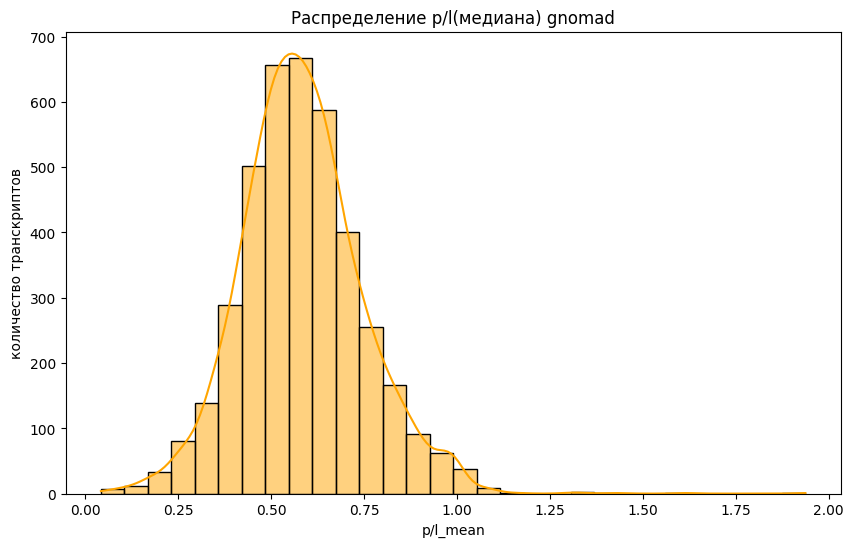

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(agg['p_l_median'], bins =30, kde=True, color="orange")
plt.title("Распределение p/l(медиана) gnomad")
plt.xlabel("p/l_mean")
plt.ylabel("количество транскриптов")
plt.show()


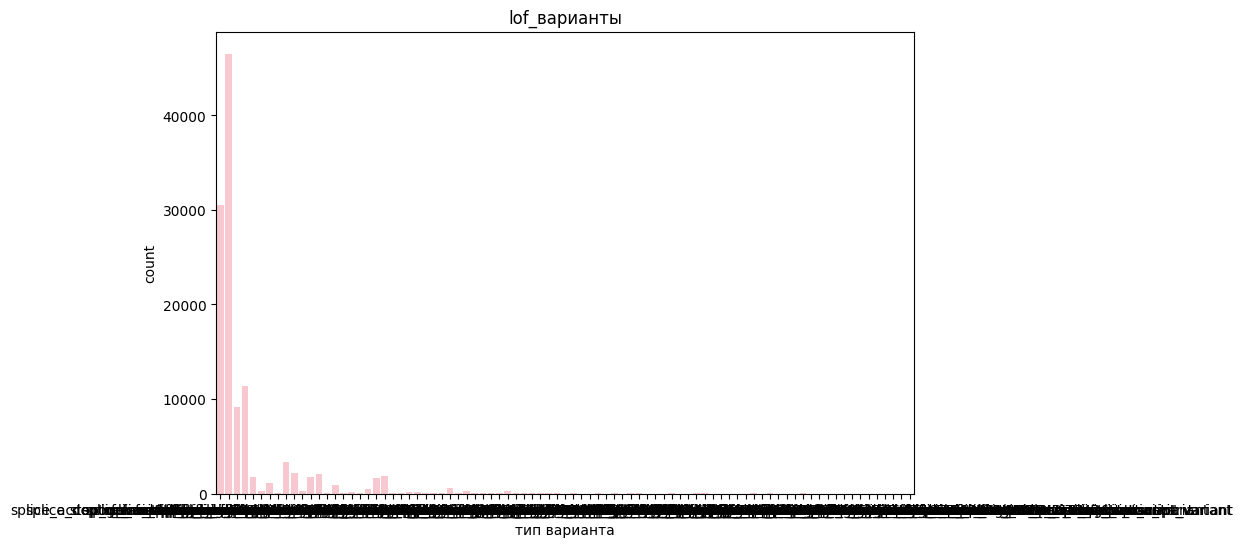

In [ ]:
listik= ['frameshift_variant',
'stop_gained'  ,
'splice_donor_variant'  ,
'splice_acceptor_variant']
plt.figure(figsize=(9, 6))
sns.countplot(data= df_final_filtered, x= 'Consequence',   color="pink")
plt.title("lof_варианты")
plt.xlabel("тип варианта")
plt.ylabel("count")
plt.show()

разделяю на норм p/l и пустые

сделать статистику по lof по классифицировать